In [1]:
import sys
import numpy as np
from sklearn.preprocessing import OneHotEncoder
#import inference
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

l1 = 0.000 # regularization
nloop = 20

s0 = np.loadtxt('s0_simulated_original.txt')
w0 = np.loadtxt('w0.txt') 
# convert to onehot
onehot_encoder = OneHotEncoder(sparse=False)
s = onehot_encoder.fit_transform(s0)

In [3]:
n = s0.shape[1]
mx = np.array([len(np.unique(s0[:,i])) for i in range(n)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

In [4]:
def fit_multiplicative_new(x,y,nloop=20):
    mx = x.shape[1]
    my = y.shape[1]

    y2 = 2*y-1

    x_av = x.mean(axis=0)
    dx = x - x_av
    c = np.cov(dx,rowvar=False,bias=True)
    c_inv = linalg.pinvh(c)

    w = np.random.normal(0.0,1./np.sqrt(mx),size=(mx,my))
    h0 = np.random.normal(0.0,1./np.sqrt(mx),size=my)

    cost = np.full(nloop,100.)         
    for iloop in range(nloop):
        h = h0[np.newaxis,:] + x.dot(w)

        p = np.exp(h)
        p_sum = p.sum(axis=1)       

        p2 = p_sum[:,np.newaxis] - p
        h2 = np.log(p2)

        hh2 = h-h2
        model_ex = np.tanh(hh2/2)

        cost[iloop] = ((y2 - model_ex)**2).mean()
        if iloop > 0 and cost[iloop] >= cost[iloop-1]: break
        #print(cost[iloop])

        t = hh2 !=0    
        h[t] = h2[t] + y2[t]*hh2[t]/model_ex[t]
        h[~t] = h2[~t] + y2[~t]*2

        h_av = h.mean(axis=0)
        dh = h - h_av

        dhdx = dh[:,np.newaxis,:]*dx[:,:,np.newaxis]
        dhdx_av = dhdx.mean(axis=0)
        w = c_inv.dot(dhdx_av)            
        w -= w.mean(axis=0) 

        h0 = h_av - x_av.dot(w)
        h0 -= h0.mean() 
    return w,h0,cost,iloop

In [5]:
# inferring h0 and w
mx_sum = mx.sum()
my_sum = mx.sum() #!!!! my_sum = mx_sum

w = np.zeros((mx_sum,my_sum))
h0 = np.zeros(my_sum)
cost = np.zeros((n,nloop))

niter = np.zeros(n)
for i0 in range(n):
    print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    w1,h01,cost1,niter1 = fit_multiplicative_new(x,y,nloop)

    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]
    
    h0[i1:i2] = h01
    cost[i0,:] = cost1
    niter[i0] = niter1

('i0:', 0)
('i0:', 1)
('i0:', 2)
('i0:', 3)
('i0:', 4)
('i0:', 5)
('i0:', 6)
('i0:', 7)
('i0:', 8)
('i0:', 9)
('i0:', 10)
('i0:', 11)
('i0:', 12)
('i0:', 13)
('i0:', 14)
('i0:', 15)
('i0:', 16)
('i0:', 17)
('i0:', 18)
('i0:', 19)


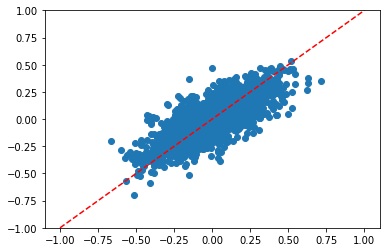

In [6]:
plt.plot([-1,1],[-1,1],'r--')
plt.ylim([-1.0,1.0])
plt.scatter(np.triu(w0),np.triu(w))
plt.show()

In [7]:
print(niter)

[ 6. 19.  8.  8.  8. 12. 10.  6.  8.  5.  6.  8.  6.  6.  9.  6.  6.  7.
  8.  8.]
